In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

import json, pdb
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

In [3]:
PATH = Path('data/pascal')
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'

In [ ]:
trn_j = json.load((PATH/'pascal_train2007.json').open())
trn_j.keys()

In [ ]:
annotations = pd.DataFrame(trn_j['annotations'])
images = pd.DataFrame(trn_j['images'])
categories = pd.DataFrame(trn_j['categories'])

In [ ]:
# {image_id: [(box coordinates, category_id),()]}

In [ ]:
annotations.head()

In [ ]:
images.head()

In [ ]:
categories.head()

In [ ]:
data = (annotations
        .merge(images, how='left', left_on='image_id', right_on='id')
        .merge(categories, how='left', left_on='category_id', right_on='id'))
data.head()

In [ ]:
# remove any ignore
# len(data) = 7844
data = data[data.ignore != 1]
len(data)

In [ ]:
# example of how to create the largest bounding box table from previous lesson

# largest_bbox = data.pivot_table(index='file_name', aggfunc='max', values='area').reset_index()
# largest_bbox = largest_bbox.merge(data[['area', 'bbox', 'image_id', 'file_name', 'name']], how='left')
# largest_bbox.head()

# Helper Functions

In [4]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [5]:
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    draw_im(im, im_a)

# Set up dataframe

In [ ]:
df = images[['file_name']].copy()

In [ ]:
def bb_hw_pandas(x):
    return [x[1], x[0], x[1]+x[3]-1, x[0]+x[2]-1]

In [ ]:
orig_boxes = []
diff_boxes = []
cat_names = []
cat_ids = []
for idx,r in df.iterrows():
    anno_rows = data.loc[data.file_name == r.file_name]
    boxes = anno_rows['bbox'].values.tolist()
    orig_boxes.append(np.concatenate(boxes))
    diff_boxes.append(np.concatenate([bb_hw_pandas(x) for x in boxes]))
    cat_names.append(anno_rows['name'].values.tolist())
    cat_ids.append(anno_rows['category_id'].values)
df['hw_boxes'] = [' '.join(str(p) for p in o) for o in orig_boxes]
df['b_boxes'] = [' '.join(str(p) for p in o) for o in diff_boxes]
df['cat_names'] = [' '.join(str(p) for p in o) for o in cat_names]
df['cat_ids'] = [' '.join(str(p) for p in o) for o in cat_ids]

In [ ]:
df.head()

# Multiple Classes only

In [20]:
multi_label_csv = PATH/'tmp/multi_label.csv'

In [ ]:
# df.to_csv(multi_label_csv, columns=['file_name', 'cat_names'], index=False)

In [7]:
f_model = resnet34
sz = 224
bs = 64

In [21]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, multi_label_csv, tfms=tfms, bs=bs)
learn = ConvLearner.pretrained(f_model, md)
learn.opt_fn = optim.Adam

/home/paperspace/fastai/courses/dl2/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/paperspace/fastai/courses/dl2/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [22]:
learn.lr_find()

epoch      trn_loss   val_loss   <lambda>                  
    0      1.083884   11.811324  0.5722    



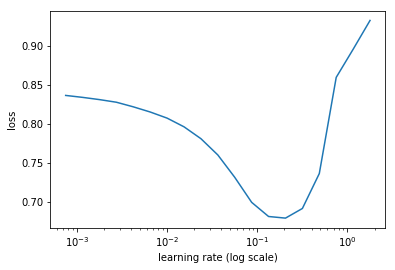

In [23]:
learn.sched.plot(n_skip_end=2)

In [24]:
lr = 6e-2

In [27]:
learn.fit(lr, 1, cycle_len=1, use_clr=(32,5))

epoch      trn_loss   val_loss   <lambda>                  
    0      0.11628    0.092335   0.9727    



[0.09233545166254044, 0.9726999917030335]

In [28]:
lrs = np.array([lr/100, lr/10, lr])

In [29]:
learn.freeze_to(-2)

In [ ]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [30]:
learn.fit(lrs/10, 1, cycle_len=5, use_clr=(32,5))

epoch      trn_loss   val_loss   <lambda>                   
    0      0.103236   0.155578   0.96      
    1      0.095711   0.113873   0.967                      
    2      0.074212   0.092019   0.9705                     
    3      0.053307   0.090675   0.9712                     
    4      0.037899   0.090125   0.9729                     



[0.09012477153539658, 0.97289999294281]

In [31]:
learn.save('multi-label')

In [32]:
y = learn.predict()
x,_ = next(iter(md.val_dl))
x = to_np(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


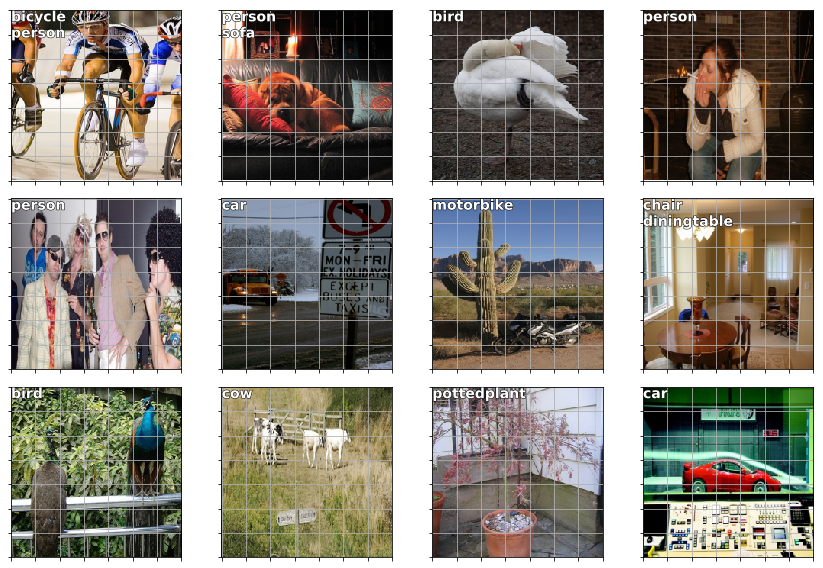

In [33]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(x)[i]
    ya = np.nonzero(y[i]>0.4)[0]
    b = '\n'.join(md.classes[o] for o in ya)
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()

# Multiple Bounding Boxes only

In [34]:
multi_box_csv = PATH/'tmp/multi_box.csv'

In [ ]:
# df.to_csv(multi_box_csv, columns=['file_name', 'b_boxes'], index=False)

In [37]:
tfm_y = TfmType.COORD
aug_tfms = [RandomRotate(3, p=0.5, tfm_y=tfm_y),
            RandomLighting(0.05, 0.05, tfm_y=tfm_y),
            RandomFlip(tfm_y=tfm_y)]

tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=tfm_y, aug_tfms=aug_tfms)
md = ImageClassifierData.from_csv(PATH, JPEGS, multi_box_csv, tfms=tfms, bs=bs, continuous=True)

In [39]:
k = 4
head_reg4 = nn.Sequential(
    nn.Conv2d(512,256,3,stride=2,padding=1),
    nn.BatchNorm2d(256),
    nn.Dropout(0.1),
    nn.Conv2d(256, 4*k, 3, padding=1)
)

learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
learn.opt_fn = optim.Adam
# learn.crit = nn.L1Loss()

In [41]:
# tensor has to be a specific shape but number of labels can vary from image to image
# fastai pads with zeros to accomodate this
# this function is getting rid of the unnecessary zeros
def get_y(bbox,clas):
    bbox = bbox.view(-1,4)/sz
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
    return bbox[bb_keep],clas[bb_keep]

# activation to bounding box
# need to convert activations into some way of scaling default anchor box positions
# shift the centers/height and width -> up to half the size of the box
def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def ssd_1_loss(b_c,b_bb,bbox,clas,print_it=False):
    bbox,clas = get_y(bbox,clas)
    a_ic = actn_to_bb(b_bb, anchors)
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,print_it)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[1-pos] = len(id2cat)
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss  = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

def ssd_loss(pred,targ,print_it=False):
    lcs,lls = 0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred,*targ):
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls+lcs

In [40]:
learn.lr_find()

  0%|          | 0/32 [00:00<?, ?it/s]


RuntimeError: input and target shapes do not match: input [64 x 16 x 4 x 4], target [64 x 36] at /opt/conda/conda-bld/pytorch_1524586445097/work/aten/src/THCUNN/generic/AbsCriterion.cu:15

# Multiple Objects

In [ ]:
multi_object_csv = PATH/'tmp/multi_object.csv'

In [ ]:
# df.to_csv(multi_object_csv, columns=['file_name', 'b_boxes', 'cat_ids'], index=False)